# Relating protein structure and post-translational modifications

The goal is to characterize whether various types of post-translational modifications (PTMs) occur more frequently in intrinsically disordered regions (IDRs) of proteins (1). The target of inference is the odds ratio associating being in an IDR and having a PTM.
This notebook shows how to do inference on the odds ratio via PPI by using structures predicted by AlphaFold (2) to predict IDRs. IDRs are predicted from structures following the strategy of Bludau et al. (3).

1. L. M. Iakoucheva, P. Radivojac, C. J. Brown, T. R. O’Connor, J. G. Sikes, Z. Obradovic, A. K. Dunker, The importance of intrinsic disorder for protein phosphorylation. Nucleic Acids Res. 32, 1037–1049 (2004).
2. J. Jumper, R. Evans, A. Pritzel, T. Green, M. Figurnov, O. Ronneberger, K. Tunyasuvunakool, R. Bates, A. Žídek, A. Potapenko, A. Bridgland, C. Meyer, S. A. A. Kohl, A. J. Ballard, A. Cowie, B. Romera-Paredes, S. Nikolov, R. Jain, J. Adler, T. Back, S. Petersen, D. Reiman, E. Clancy, M. Zielinski, M. Steinegger, M. Pacholska, T. Berghammer, S. Bodenstein, D. Silver, O. Vinyals, A. W. Senior, K. Kavukcuoglu, P. Kohli, D. Hassabis, Highly accurate protein structure prediction with AlphaFold. Nature 596(7873), 583–589 (2021). 
3. I. Bludau, S. Willems, W-F. Zeng, M. T. Strauss, F. M. Hansen, M. C. Tanzer, O. Karayel, B. A. Schulman, M. Mann, The structural context of posttranslational modifications at a proteome-wide scale. PLoS Biology 20(5), e3001636 (2022).

### Import necessary packages

In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_mean_ci, classical_mean_ci
from tqdm import tqdm
from scipy.optimize import brentq
from utils import *

### Import the AlphaFold data set

Load the data. The data set contains true indicators of disorder (```Y```), predicted indicators of disorder (```Yhat```), and indicators of a PTM (```phosphorylated```, ```ubiquitinated```, or ```acetylated```). Predictions of disorder are made based on AlphaFold predictions of structure.

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "alphafold")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
Z = data["phosphorylated"].astype(
    bool
)  # Can choose from "phosphorylated", "ubiquitinated", or "acetylated"

Dataset alphafold not found at location ./data/; downloading now...


Downloading...
From: https://drive.google.com/uc?id=1lOhdSJEcFbZmcIoqmlLxo3LgLG1KqPho
To: /home/aa/Code/ppi_py/examples/data/alphafold.npz
100%|██████████| 433k/433k [00:00<00:00, 4.71MB/s]


### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand.

In [3]:
alpha = 0.1
ns = np.array(
    [200, 400, 800, 1500, 3000]
)  # Test for different numbers of labels
num_trials = 100

# Split into two subgroups for odds ratio calculation
Y0_total, Y1_total = Y_total[~Z], Y_total[Z]
Yhat0_total, Yhat1_total = Yhat_total[~Z], Yhat_total[Z]
n0_total = Y0_total.shape[0]
n1_total = Y1_total.shape[0]
sample_ratio = n0_total / Y_total.shape[0]

# True odds ratio
mu0 = Y0_total.mean()
mu1 = Y1_total.mean()
odds_ratio = (mu1 / (1 - mu1)) / (mu0 / (1 - mu0))

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Imputation```)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [4]:
def odds_ratio_ci(mu0_ci, mu1_ci):
    # First construct CI of mu0/(1-mu0) and mu1/(1-mu1)
    r0 = [mu0_ci[0] / (1 - mu0_ci[0]), mu0_ci[1] / (1 - mu0_ci[1])]
    r1 = [mu1_ci[0] / (1 - mu1_ci[0]), mu1_ci[1] / (1 - mu1_ci[1])]
    return r1[0] / r0[1], r1[1] / r0[0]

In [5]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Split the data
        n = ns[i]
        _n0 = int(n * sample_ratio)
        _n1 = n - _n0
        rand_idx_0 = np.random.permutation(n0_total)
        rand_idx_1 = np.random.permutation(n1_total)
        _Yhat0 = Yhat0_total[rand_idx_0[:_n0]]
        _Y0 = Y0_total[rand_idx_0[:_n0]]
        _Yhat0_unlabeled = Yhat0_total[rand_idx_0[_n0:]]
        _Yhat1 = Yhat1_total[rand_idx_1[:_n1]]
        _Y1 = Y1_total[rand_idx_1[:_n1]]
        _Yhat1_unlabeled = Yhat1_total[rand_idx_1[_n1:]]

        # PPI
        ppi_mu0_ci = ppi_mean_ci(
            _Y0, _Yhat0, _Yhat0_unlabeled, alpha=alpha / 2
        )
        ppi_mu1_ci = ppi_mean_ci(
            _Y1, _Yhat1, _Yhat1_unlabeled, alpha=alpha / 2
        )
        ppi_odds_ratio_ci = odds_ratio_ci(ppi_mu0_ci, ppi_mu1_ci)

        # Classical interval
        classical_mu0_ci = classical_mean_ci(_Y0, alpha=alpha / 2)
        classical_mu1_ci = classical_mean_ci(_Y1, alpha=alpha / 2)
        classical_odds_ratio_ci = odds_ratio_ci(
            classical_mu0_ci, classical_mu1_ci
        )

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_odds_ratio_ci[0],
                        "upper": ppi_odds_ratio_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_odds_ratio_ci[0],
                        "upper": classical_odds_ratio_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_mu0_ci = classical_mean_ci(
    (Yhat0_total > 0.5).astype(int), alpha=alpha / 2
)
imputed_mu1_ci = classical_mean_ci(
    (Yhat1_total > 0.5).astype(int), alpha=alpha / 2
)
imputed_odds_ratio_ci = odds_ratio_ci(imputed_mu0_ci, imputed_mu1_ci)

results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_odds_ratio_ci[0],
                "upper": imputed_odds_ratio_ci[1],
                "trial": 0,
            }
        ]
    )
]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI and the classical method, and the imputed interval;
2. The average interval width for PPI and the classical method, together with a scatterplot of the widths from the five random draws.

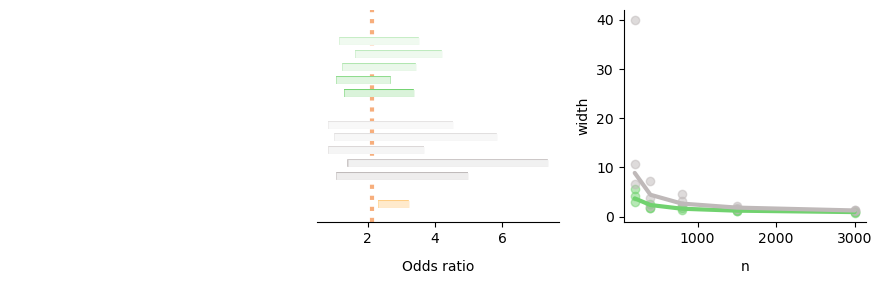

In [6]:
make_plots(
    df,
    "./plots/alphafold.pdf",
    intervals_xlabel="Odds ratio",
    n_idx=1,
    true_theta=odds_ratio,
)

### Power experiment

For PPI and the classical approach, find the smallest value of ```n``` such that the method has power 80% against the null $H_0: \text{odds ratio} \leq 1$.

In [7]:
# Find n such that we reject H0: odds ratio <= 1 with probability 80% using a test at level alpha
num_experiments = 100
list_rand_idx_0 = [
    np.random.permutation(n0_total) for i in range(num_experiments)
]
list_rand_idx_1 = [
    np.random.permutation(n1_total) for i in range(num_experiments)
]

alpha_pval = 0.05


def _to_invert_ppi(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        _n0 = int(n * sample_ratio)
        _n1 = n - _n0
        rand_idx_0 = list_rand_idx_0[i]
        rand_idx_1 = list_rand_idx_1[i]
        _Yhat0 = Yhat0_total[rand_idx_0[:_n0]]
        _Y0 = Y0_total[rand_idx_0[:_n0]]
        _Yhat0_unlabeled = Yhat0_total[rand_idx_0[_n0:]]
        _Yhat1 = Yhat1_total[rand_idx_1[:_n1]]
        _Y1 = Y1_total[rand_idx_1[:_n1]]
        _Yhat1_unlabeled = Yhat1_total[rand_idx_1[_n1:]]

        # PPI
        ppi_mu0_ci = ppi_mean_ci(
            _Y0, _Yhat0, _Yhat0_unlabeled, alpha=alpha_pval / 2
        )
        ppi_mu1_ci = ppi_mean_ci(
            _Y1, _Yhat1, _Yhat1_unlabeled, alpha=alpha_pval / 2
        )
        ppi_odds_ratio_ci = odds_ratio_ci(ppi_mu0_ci, ppi_mu1_ci)
        if ppi_odds_ratio_ci[0] > 1:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8


def _to_invert_classical(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        _n0 = int(n * sample_ratio)
        _n1 = n - _n0
        rand_idx_0 = list_rand_idx_0[i]
        rand_idx_1 = list_rand_idx_1[i]
        _Yhat0 = Yhat0_total[rand_idx_0[:_n0]]
        _Y0 = Y0_total[rand_idx_0[:_n0]]
        _Yhat0_unlabeled = Yhat0_total[rand_idx_0[_n0:]]
        _Yhat1 = Yhat1_total[rand_idx_1[:_n1]]
        _Y1 = Y1_total[rand_idx_1[:_n1]]
        _Yhat1_unlabeled = Yhat1_total[rand_idx_1[_n1:]]

        # Classical interval
        classical_mu0_ci = classical_mean_ci(_Y0, alpha=alpha_pval / 2)
        classical_mu1_ci = classical_mean_ci(_Y1, alpha=alpha_pval / 2)
        classical_odds_ratio_ci = odds_ratio_ci(
            classical_mu0_ci, classical_mu1_ci
        )
        if classical_odds_ratio_ci[0] > 1:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8

In [8]:
n_ppi = int(brentq(_to_invert_ppi, 10, 3000, xtol=1))
n_classical = int(brentq(_to_invert_classical, 10, 3000, xtol=1))
print(
    f"The PPI test requires n={n_ppi} labeled data points to reject the null."
)
print(
    f"The classical test requires n={n_classical} labeled data points to reject the null."
)

/tmp/ipykernel_207554/1679104075.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  return r1[0] / r0[1], r1[1] / r0[0]
/tmp/ipykernel_207554/1679104075.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return r1[0] / r0[1], r1[1] / r0[0]


The PPI test requires n=296 labeled data points to reject the null.
The classical test requires n=920 labeled data points to reject the null.
